# Example of Fitting NuSTAR Spectra

This notebook provides a quick overlook of the fitting code in SunXspex and some real examples of fitting NuSTAR spectra with comparisons to published works.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
from sys import path as sys_path
sys_path.append('../sunxspex')
from sunxspex.sunxspex_fitting.fitter import SunXspex

In [3]:
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

## Set up some plotting numbers

In [4]:
spec_single_plot_size = (8,10)
spec_plot_size = (25,10)
spec_font_size = 18
default_font_size = 10
x_limits, y_limits = [1.6,8.5], [1e-1,1e3]

# Load in one spectrum and fit it with one model

In [5]:
# First, load in your data files, here we load in 1 spectrum
_dir = "../nustarData/m3_time2628/"
spec = SunXspex(pha_file=[_dir+'nu80414202001A06_chu23_S_cl_grade0_sr.pha'])
                
# All the data can be accessed via spec.loaded_spec_data
                
# Next you can define a model, here we go for a single isothermal model
spec.model = "f_vth"

And all data can be accessed via `spec.loaded_spec_data`.

In [6]:
print(spec.params)

              Status  Value       Bounds       Error
T1_spectrum1    free    1.0  (0.0, None)  (0.0, 0.0)
EM1_spectrum1   free    1.0  (0.0, None)  (0.0, 0.0)


In [7]:
# Set your count energy fitting range. Here we choose 2.5--8.1 keV
spec.energy_fitting_range = [2.5,8.1]

To set the initial value and boundary of your parameters we can do the following:

In [8]:
spec.params["T1_spectrum1"] = {"Value":4, "Bounds":(2.5, 8)} # units MK
spec.params["EM1_spectrum1"] = {"Value":0.3, "Bounds":(1e-2, 8e-1)} # units 1e46 cm^-3

Setting `spec.params["param_spec"] = string` will set the Status, `spec.params["param_spec"] = int or float` will set the Value, `spec.params["param_spec"] = tuple` will set the Bounds.

I.e., `spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)}` is the same as doing `spec.params["T1_spectrum1"]=3.05` and then `spec.params["T1_spectrum1"]=(2.5, 6)`.

In [9]:
print(spec.params)

              Status  Value       Bounds       Error
T1_spectrum1    free    4.0     (2.5, 8)  (0.0, 0.0)
EM1_spectrum1   free    0.3  (0.01, 0.8)  (0.0, 0.0)


Once data has been loaded and a model set then the data can be fit with:

Any kwargs passed to fit will be sent to Scipy's minimize, e.g., tol=1e-6 for setting a tolerance for the fit.

In [10]:
%%time

minimised_params = spec.fit()

CPU times: user 2.72 s, sys: 656 ms, total: 3.38 s
Wall time: 994 ms


The spec.params will be updated with the best fit values and errors (if obtained) updated too.

In [11]:
print(spec.params)

              Status     Value       Bounds  \
T1_spectrum1    free  4.748163     (2.5, 8)   
EM1_spectrum1   free  0.303051  (0.01, 0.8)   

                                                      Error  
T1_spectrum1   (0.016572586985611096, 0.016572586985611096)  
EM1_spectrum1    (0.00458303792059048, 0.00458303792059048)  


Plot the result with the `plot` method:

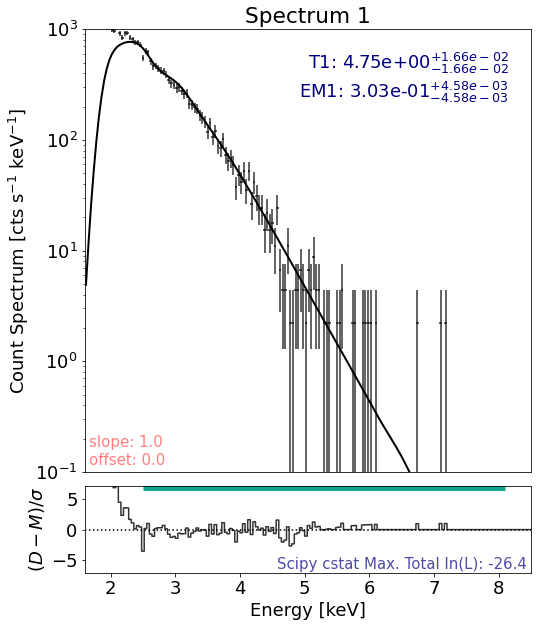

In [12]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)

# the only line needed to plot the result
axes, res_axes = spec.plot()

for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

## The data loader class

The data loader class (LoadSpec in data_loader.py) makes use of instrument specific loaders. Each instrument loader's job is to essentially create the following dictionary for each loaded spectrum, found with the attribute `_loaded_spec_data` in the instrument class which makes up the loader class's `loaded_spec_data` attribute. E.g., with NuSTAR:
```python
nust_loader._loaded_spec_data = {"photon_channel_bins":channel_bins, 
                                 "photon_channel_mids":np.mean(channel_bins, axis=1), 
                                 "photon_channel_binning":channel_binning, 
                                 "count_channel_bins":channel_bins, 
                                 "count_channel_mids":np.mean(channel_bins, axis=1), 
                                 "count_channel_binning":channel_binning, 
                                 "counts":counts, 
                                 "count_rate":count_rate, 
                                 "count_rate_error":count_rate_error, 
                                 "effective_exposure":eff_exp,
                                 "srm":srm,
                                 "extras":{"pha.file":f_pha,
                                           "arf.file":f_arf,
                                           "arf.e_lo":e_lo_arf,
                                           "arf.e_hi":e_hi_arf,
                                           "arf.effective_area":eff_area,
                                           "rmf.file":f_rmf,
                                           "rmf.e_lo":e_lo_rmf,
                                           "rmf.e_hi":e_hi_rmf,
                                           "rmf.ngrp":ngrp,
                                           "rmf.fchan":fchan,
                                           "rmf.nchan":nchan,
                                           "rmf.matrix":matrix,
                                           "rmf.redistribution_matrix":redist_m} 
                                }
```
such that,
```python
self.loaded_spec_data = {"spectrum1":inst_loader, ...}
```

### Multiple ways to set the fitting range

Fit the energy range while missing bins:

In [13]:
spec.energy_fitting_range = [[2.5,4], [4.5,8.1]]
# This only will fit the counts from 2.5--4 keV and 4.5--8.1 keV and is applied to all spectra loaded

### Rebin the data (not just for plotting)

Rebin all the count data being fitted to have a minimum of 4 counts in a bin, any counts left over will not be included and the user will be told.

In [14]:
spec.rebin = 4
# or equivalently
spec.rebin = {"all":4}
# or equivalently if just one spectrum is loaded
spec.rebin = {"spectrum1":4}

In spectrum1: 1  counts are left over from binning (bin min. 4) and will not be included when fitting or shown when plotted.
In spectrum1: 1  counts are left over from binning (bin min. 4) and will not be included when fitting or shown when plotted.
In spectrum1: 1  counts are left over from binning (bin min. 4) and will not be included when fitting or shown when plotted.


### Undo the rebinning of the data

To revert back to native binning for all spectra:

In [15]:
spec.undo_rebin 
# or equivalently for one spectrum
spec.undo_rebin = "spectrum1"
# or (indicate the spectrum with just its number)
spec.undo_rebin = 1
# or explicitly state the rebinning should be reverted to all spectra
spec.undo_rebin = "all"

Nothing to undo in spectrum1 as data has not been rebinned.
Nothing to undo in spectrum1 as data has not been rebinned.
Nothing to undo in spectrum1 as data has not been rebinned.


### Save what you have

To save the fitting class to a file called 'test.pickle'.

In [16]:
spec.save("../savedFits/test.pickle")

Load it back in and continue analysis:

In [17]:
# To load a saved session back in 
from sunxspex.sunxspex_fitting.fitter import load
new_spec = load("../savedFits/test.pickle")

print(new_spec.params)

# run fit again since the energy range being fitted over has been changed after the last fit
new_spec.fit(tol=1e-6) # Scipy minimize tolerance of 1e-6

              Status     Value       Bounds  \
T1_spectrum1    free  4.748163     (2.5, 8)   
EM1_spectrum1   free  0.303051  (0.01, 0.8)   

                                                      Error  
T1_spectrum1   (0.016572586985611096, 0.016572586985611096)  
EM1_spectrum1    (0.00458303792059048, 0.00458303792059048)  


[4.662741953391822, 0.32858290053833533]

Plot the data and rebin it **just for plotting**, fit was in natural binning

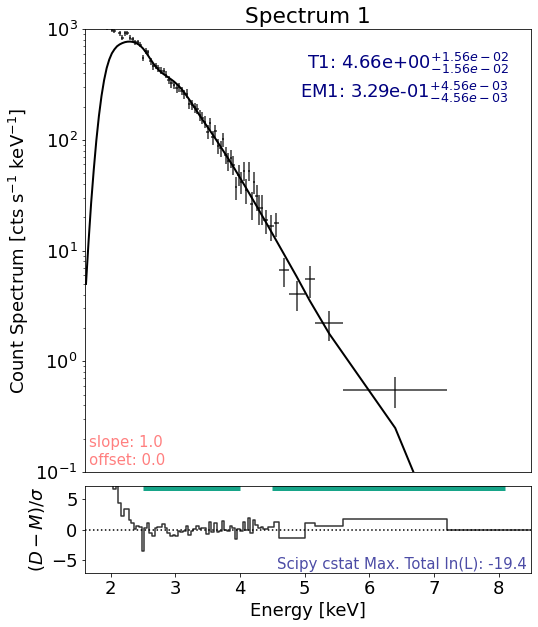

In [18]:
# rebin=10 means the count bins were combined so that all bins had at least 10 counts in them or were ignored
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = new_spec.plot(rebin=10)
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

# Easily run an MCMC on your data with your model

In [19]:
mcmc_result = spec.run_mcmc()

100%|███████████████████████████████████████| 1200/1200 [01:10<00:00, 17.10it/s]


To add more MCMC runs when running the it again instead of overwriting, set ```append_runs=True```.

In [20]:
mcmc_result = spec.run_mcmc(steps_per_walker=200, append_runs=True)

100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 17.75it/s]


MCMC runs are easily burned and are always burned from the original sampling. E.g., burning 50 samples twice still only discards 50 samples, to discard 100 the user needs to just discard 100.

In [21]:
spec.burn_mcmc = 100

Plot the log-probability chains

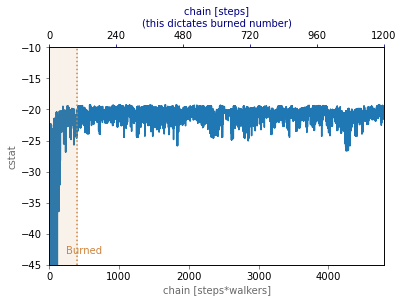

In [22]:
plt.figure()
spec.plot_log_prob_chain()
plt.ylim([-45,-10])
plt.show()

Plot the corner plot from the MCMC run (just send the data to corner.py)

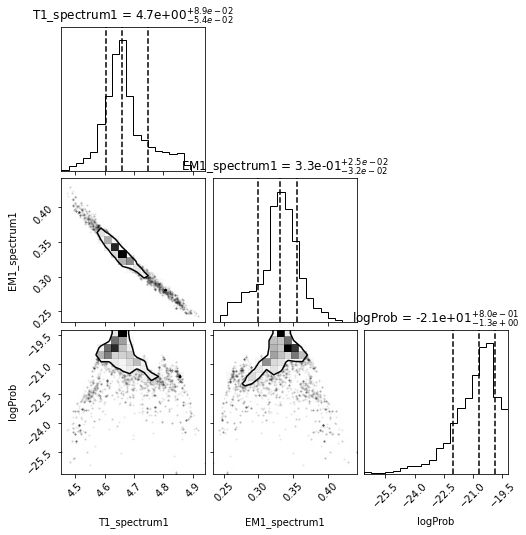

In [23]:
corner_plot = spec.corner_mcmc()

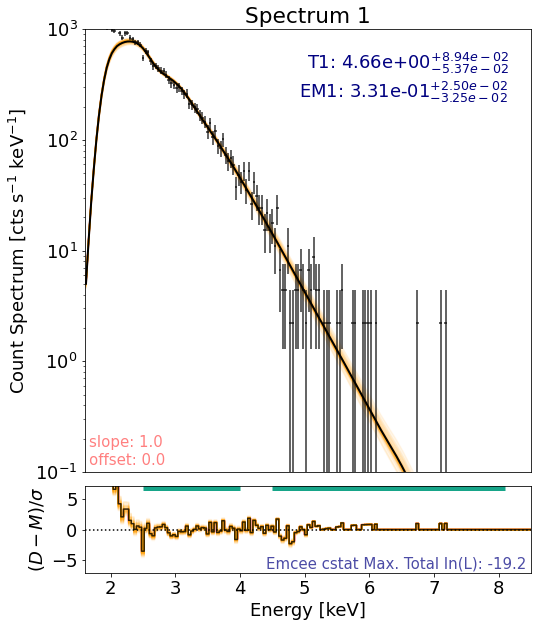

In [24]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

**Note** that the log-likelihood displayed on the spectral plots show the the maximum log-likelihood found in the MCMC run, not the log-likelihood of the maximum a posteriori (MAP) fit plotted.

The log-likelihoods of the median and confidence ranges can be found on the corner plot at the minute and the parameter values that produce these can be found with the `mcmc_table` attribute.

In [25]:
spec.mcmc_table

Param,LowB,Mid,HighB,MaxLog
str13,float64,float64,float64,float64
T1_spectrum1,4.60,4.66,4.75,4.66
EM1_spectrum1,0.30,0.33,0.36,0.33


An alternative to plotting a number of random MCMC samples as faded lines being the MAP the user can plot a colour map showing where all run models (that are not burned) accumulate counts. This will obviously take longer.

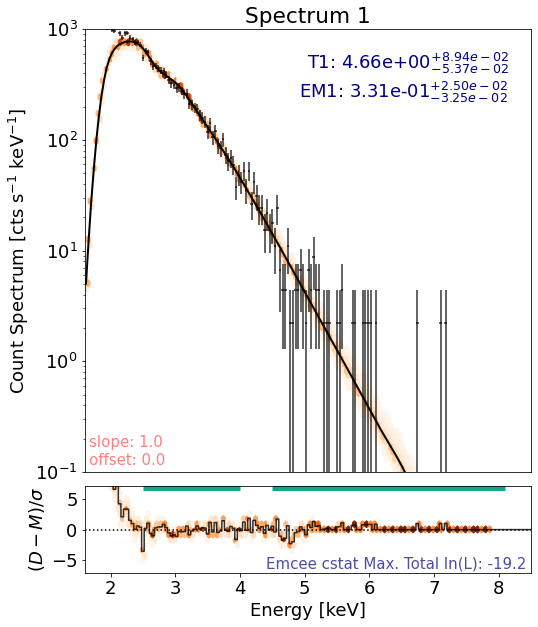

In [26]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot(hex_grid=True)
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

# Might want to fit multiple models and NuSTAR has 2 telescopes so...

## Fit 2 spectra simultaneously with two thermal models

Model parameters are tied to spectrum 1's parameters by default.

In [27]:
%%time
# load in your data files, here we load in 2 spectra
_dir = "../nustarData/m10_1616_1620/"
spec = SunXspex(pha_file=[_dir+'nu80415202001A06_chu13_N_cl_grade0_sr.pha', 
                          _dir+'nu80415202001B06_chu13_N_cl_grade0_sr.pha'])
                
# Next you can define a model, here we go for a 2 component isothermal model
# C parameter accounts for systematic offset between two different telescopes
spec.model = "C*(f_vth + f_vth)"

# Set your count energy fitting range. Here we choose 2.5--8.1 keV
spec.energy_fitting_range = [2.5,8.1]
                
# Freeze parameters
# spec.params["C_spectrum1"] = "frozen" is equivalent
spec.params["C_spectrum1"] = {"Status":"frozen"}

# To set the initial value and boundary of your parameters we can do the following.
spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)}
spec.params["EM1_spectrum1"] = {"Value":1.7, "Bounds":(0.5, 3.5)}     
spec.params["T2_spectrum1"] = {"Value":6.6, "Bounds":(4, 10)}                
spec.params["EM2_spectrum1"] = {"Value":0.004, "Bounds":(1e-4, 2e-1)}        

# free the constant (was tied to C_spectrum1) to account for systematic offset between NuSTAR FPMs
spec.params["C_spectrum2"] = {"Status":"free", "Bounds":(0.5, 2)}
                
print(spec.params)

                          Status  Value         Bounds       Error
T1_spectrum1                free  3.050       (2.5, 6)  (0.0, 0.0)
EM1_spectrum1               free  1.700     (0.5, 3.5)  (0.0, 0.0)
T2_spectrum1                free  6.600        (4, 10)  (0.0, 0.0)
EM2_spectrum1               free  0.004  (0.0001, 0.2)  (0.0, 0.0)
C_spectrum1               frozen  1.000    (0.0, None)  (0.0, 0.0)
T1_spectrum2    tie_T1_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
EM1_spectrum2  tie_EM1_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
T2_spectrum2    tie_T2_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
EM2_spectrum2  tie_EM2_spectrum1  1.000    (0.0, None)  (0.0, 0.0)
C_spectrum2                 free  1.000       (0.5, 2)  (0.0, 0.0)
CPU times: user 3.44 s, sys: 387 ms, total: 3.83 s
Wall time: 4.33 s


In [28]:
# can also display parameter table as an astropy table
print(spec.show_params)

    Param           Status      ...     Bounds             Error          
                                ...   (min, max)           (-, +)         
------------- ----------------- ... ------------- ------------------------
 T1_spectrum1              free ...      (2.5, 6) (  0.00e+00,   0.00e+00)
EM1_spectrum1              free ...    (0.5, 3.5) (  0.00e+00,   0.00e+00)
 T2_spectrum1              free ...       (4, 10) (  0.00e+00,   0.00e+00)
EM2_spectrum1              free ... (0.0001, 0.2) (  0.00e+00,   0.00e+00)
  C_spectrum1            frozen ...   (0.0, None) (  0.00e+00,   0.00e+00)
 T1_spectrum2  tie_T1_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
EM1_spectrum2 tie_EM1_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
 T2_spectrum2  tie_T2_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
EM2_spectrum2 tie_EM2_spectrum1 ...   (0.0, None) (  0.00e+00,   0.00e+00)
  C_spectrum2              free ...      (0.5, 2) (  0.00e+00,   0.00e+00)
    Fit Stat.       cstat

Fit and plot

In spectrum1: 1  counts are left over from binning (bin min. 5) and will not be included when fitting or shown when plotted.
In spectrum2: 1  counts are left over from binning (bin min. 5) and will not be included when fitting or shown when plotted.
In combined: 1.5  counts are left over from binning (bin min. 5) and will not be included when fitting or shown when plotted.


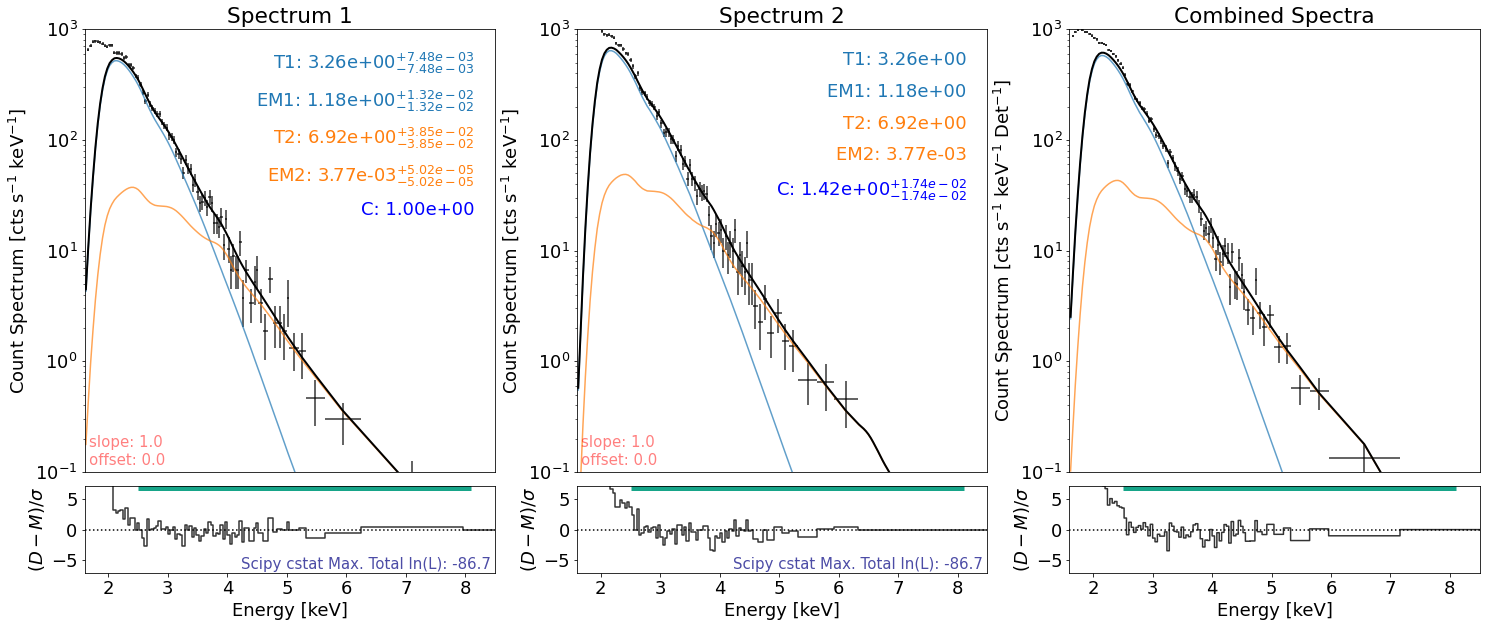

In [29]:
minimised_params = spec.fit()

plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot(rebin=5)
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

Compare to XSPEC fits of the same spectra (microflare 10, pre-flare, from [cooper *et al.* 2021](https://academic.oup.com/mnras/article/507/3/3936/6354806)):

| Model Parameter                | XSPEC (Cooper et al. 2021)            | This Work                       |
| :---                           |    :----:                             |                            ---: |
| Temperature 1 [MK]             | 3.05$^{+0.04}_{-0.35}$                | 3.26$\pm$0.01                   |
| Emission Measure 1 [cm$^{-3}$] | 1.70$^{+1.99}_{-0.08}\times$10$^{47}$ | 1.18$\pm$0.01$\times$10$^{46}$  |
| Temperature 2 [MK]             | 6.60$^{+0.20}_{-0.61}$                | 6.92$\pm$0.04                   |
| Emission Measure 2 [cm$^{-3}$] | 3.8$^{+4.0}_{-0.7}\times$10$^{43}$    | 3.77$\pm$0.05$\times$10$^{43}$  |

Although these values are slightly different (almost or are within error margins), it is important to note that XSPEC and SunXspex work from different atomic databases. We also note that for a similar isothermal fit the temperature can drop/rise if the emission measure rises/drops and so fitting not just one but two of these models allows for these to vary more. We do see that this work (for this microflare time) produces slightly higher temperatures but correspondingly lower emission measures. 

The errors in this code also work under a Gaussian and independent assumption and so are likely underestimating the true error on each parameter.

### A Note On Parameter Handling

**Setting spec.params["param_spec"] = string will set the Status, spec.params["param_spec"] = int or float will set the Value, spec.params["param_spec"] = tuple will set the Bounds.** E.g.,
```python
spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)} 
```
is the same as doing 
```python
spec.params["T1_spectrum1"] = 3.05 
spec.params["T1_spectrum1"] = (2.5, 6)
```
or 
```python
spec.params["T1_spectrum1"] = [3.05, (2.5, 6)]
```

***

**To tie one parameter to another** we can either set that parameter to the one we want to tie it to or use ["tie", "tied", "bind", "tether", "join", "joined", "in_a_relationship_with"] with _param_to_tie_to. E.g.,
```python
spec.params["EM1_spectrum2"] = spec.params["EM1_spectrum1"]
spec.params["EM1_spectrum2"] = "JoIn_EM1_spectrum1"
spec.params["EM1_spectrum2"] = {"Status":"bind_EM1_spectrum1"}
```

**To stop a parameter from varying** we can set its Status to ["frozen", "freeze", "chill", "fix", "fixed", "secure", "stick", "glue", "preserve", "cannot_move", "cant_move", "canny_move", "married"]. E.g.,
```python
spec.params["C_spectrum1"] = "fix" 
spec.params["C_spectrum1"] = {"Status":"frozen"}
```

**To allow a parameter to vary** after being fixed simply set its Status to any of these ["free", "thaw", "loose", "unrestrained", "release", "released", "can_move", "single"]. E.g.,
```python
spec.params["C_spectrum1"] = "free" 
spec.params["C_spectrum1"] = {"Status":"thaw"}
```

### Other (equivalent) ways to define the same model:

When defining a model in a functional form, ensure that the energies input is a keyword with default None. E.g., f(...,energies=None).

This same form is used when adding a user component (or sub-) model to be used. 

In [30]:
model_2therm = lambda T1, EM1, T2, EM2, C, energies=None: C*(f_vth(T1, EM1, energies=energies) + f_vth(T2, EM2, energies=energies))
                
def model_2therm(T1, EM1, T2, EM2, C, energies=None):
    return C*(f_vth(T1, EM1, energies=energies) + f_vth(T2, EM2, energies=energies))
                
model_2therm = "C*(f_vth + f_vth)"

spec.model = model_2therm

Model already assigned. If you want to change model please set property "update_model".


As stated, if the user wants to redefine the model and parameter tables then instead of setting `spec.model` the user can set `spec.update_model`.

If a model if defined via a string (e.g., "C*(f_vth + f_vth)") then the component models will be plotted in different colours once plotted. These other methods will only allow the total resultant model to be plotted but allow for more complex models to be created by the user. 

***

To ensure normal behaviour by all the code, make sure the function is self-contained; i.e., it can be run from its source code in a different directory. Any packages used that are not defined in the fitter module will need to be included in the function if the user wants to be able to save out and load in the fitting class and have full functionality (anything that includes pickle will not like this; e.g., parallelisation, etc.). Warnings will inform the user if their function is not self-contained and information given to help make it so.


Obviously if a package is needed that is imported outside the scope of the model function (which, when loaded back in will not be seen), or if the function is too complicated in some way, the same model can renewed in the new session via `renew_model` for any fitting to take place (this will not reset the parameter/rparameter tables).

***

If the user wants to define any sub-models (and use like `f_vth` above) then they can add these with the `add_photon_model()` function (see below).

### Set different fitting ranges for each spectrum

In spectrum1: 10  counts are left over from binning (bin min. 12) and will not be included when fitting or shown when plotted.
In spectrum2: 11  counts are left over from binning (bin min. 12) and will not be included when fitting or shown when plotted.
In combined: 9.5  counts are left over from binning (bin min. 12) and will not be included when fitting or shown when plotted.


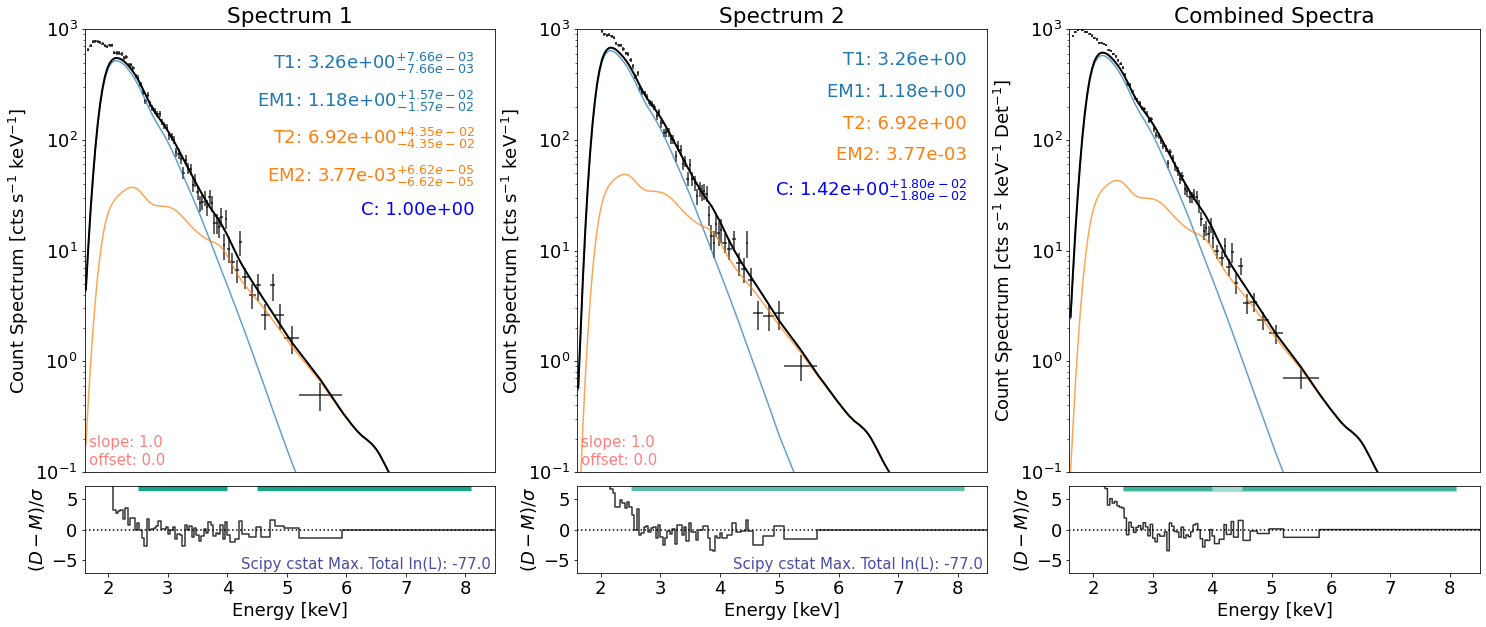

In [31]:
# To fit the energy range while missing bins:
spec.energy_fitting_range = [[2.5,4], [4.5,8.1]]
# This only will fit the counts from 2.5--4 keV and 4.5--8.1 keV and is applied to all spectra loaded

# To vary the fitting range per spectrum, say if we have two spectra loaded:
spec.energy_fitting_range = {"spectrum1":[[2.5,4], [4.5,8.1]], "spectrum2":[[2.5,8.1]]}


# then fit and plot again...
minimised_params = spec.fit()
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot(rebin=12)
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

# Add user defined sub-model

Need to add function to the correct namespace for the fitter to see it and include the function name and parameters in `defined_photon_models` dictionary. This is done using the `add_photon_model()` function.

`defined_photon_models` dict is what the SunXspex fitting uses to know what functions it can use to build with

In [32]:
from sunxspex.sunxspex_fitting.fitter import defined_photon_models, add_photon_model

See what models are defined.

At the minute this is just the already defined module models `{'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], ...}`.

In [33]:
print("Defined models:\n",defined_photon_models)

Defined models:
 {'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], 'thick_warm': ['tot_eflux', 'indx', 'ec', 'plasma_d', 'loop_temp', 'length']}


Define your sub-model in the same way you would define a total model (`f(*parameters,energies=None)`). 

Model spectrum in units of photons s^-1 cm^-2 keV^-1 here (dimensions to make `model_spectrum#spectral_response` consistent with `count_spectrum`).

Parameter names cannot be any already defined in `defined_photon_models`.

In [34]:
def gauss(a, b, c, energies=None):
    # energies is given as energy bins, e.g., [[2.5,2.6], [2.6,2.7], [2.7,2.8], ...], so...
    mid_x = np.mean(energies, axis=1) 
    return a * np.exp(-((mid_x-b)**2/(2*c**2)))

Essentially this is adding your model to the namespace that the fitting process uses to see what models are available to use:

In [35]:
add_photon_model(gauss)

Model gauss added.


Now defined_photon_models is `{'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], ..., 'gauss': ['a', 'b', 'c']}` and can use the gauss function:

In [36]:
print("Defined models, user\'s now included':\n",defined_photon_models)

Defined models, user's now included':
 {'f_vth': ['T', 'EM'], 'thick_fn': ['total_eflux', 'index', 'e_c'], 'thick_warm': ['tot_eflux', 'indx', 'ec', 'plasma_d', 'loop_temp', 'length'], 'gauss': ['a', 'b', 'c']}


Now can use the user defined gauss model with already defined module models:

In [37]:
# E.g. (use .update_model since the last one was "C*(f_vth + f_vth)" and still exists for spec object)
spec.update_model = "f_vth+gauss"

# spec.params.param_name -> [T1_spectrum1,EM1_spectrum1,a1_spectrum1,b1_spectrum1,c1_spectrum1]
print("Parameters\n",spec.params)

Parameters
                           Status  Value       Bounds       Error
T1_spectrum1                free    1.0  (0.0, None)  (0.0, 0.0)
EM1_spectrum1               free    1.0  (0.0, None)  (0.0, 0.0)
a1_spectrum1                free    1.0  (0.0, None)  (0.0, 0.0)
b1_spectrum1                free    1.0  (0.0, None)  (0.0, 0.0)
c1_spectrum1                free    1.0  (0.0, None)  (0.0, 0.0)
T1_spectrum2    tie_T1_spectrum1    1.0  (0.0, None)  (0.0, 0.0)
EM1_spectrum2  tie_EM1_spectrum1    1.0  (0.0, None)  (0.0, 0.0)
a1_spectrum2    tie_a1_spectrum1    1.0  (0.0, None)  (0.0, 0.0)
b1_spectrum2    tie_b1_spectrum1    1.0  (0.0, None)  (0.0, 0.0)
c1_spectrum2    tie_c1_spectrum1    1.0  (0.0, None)  (0.0, 0.0)


#### Can now use gauss photon model in the fitting, either by itself or in a greater, overall model defined as a named function, lambda function, or string

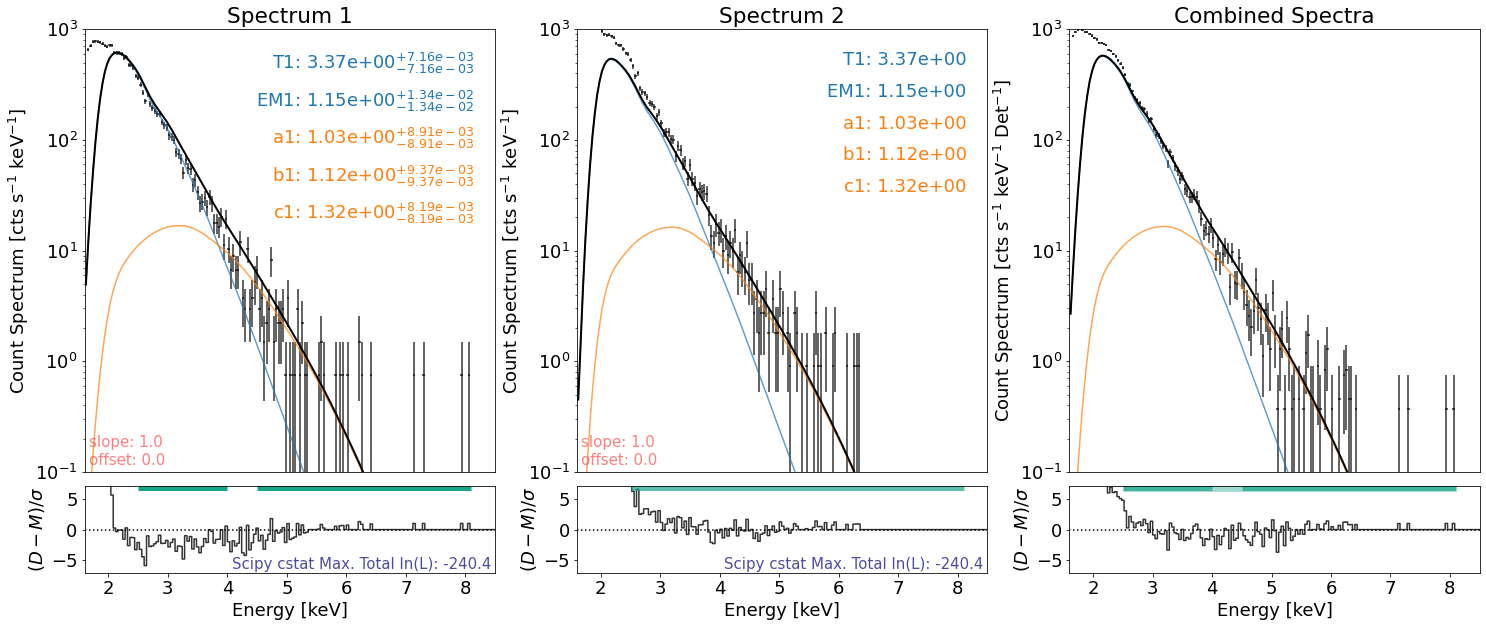

In [38]:
# sort parameters
spec.params["T1_spectrum1"] = {"Value":3.05, "Bounds":(2.5, 6)}
spec.params["EM1_spectrum1"] = {"Value":1.7, "Bounds":(0.5, 3.5)} 

# then fit and plot again...
minimised_params = spec.fit()

plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(x_limits)
    a.set_ylim(y_limits)
plt.show()
plt.rcParams['font.size'] = default_font_size

If the user's model function requires complicated variables/constants/etc., say large array loaded from a file, then this will not be seen if the session is save and loaded back in another time. To avoid this see the `add_var` function which works in a similar way to `add_photon_model` but for variables to be seen when pickling.

In additon to `add_photon_model` and `add_var` also having an `overwrite` input they also come with methods to remove any user added models or variables, such as `del_photon_model` and `del_var` which take the model/variable name as a string, respectively.

# Can alter the gain parameters

Gain parameters can be tweaked in the same way model parameters can.

The difference is that gain parameters all have specific starting values (slope=1, offset=0) and are frozen by default.

In [39]:
print(spec.rParams)

                       Status  Value       Bounds       Error
gain_slope_spectrum1   frozen    1.0   (0.8, 1.2)  (0.0, 0.0)
gain_offset_spectrum1  frozen    0.0  (-0.1, 0.1)  (0.0, 0.0)
gain_slope_spectrum2   frozen    1.0   (0.8, 1.2)  (0.0, 0.0)
gain_offset_spectrum2  frozen    0.0  (-0.1, 0.1)  (0.0, 0.0)


In [40]:
print(spec.show_rParams)

        Param         Status   Value       Bounds            Error          
                                         (min, max)          (-, +)         
--------------------- ------ ---------- ----------- ------------------------
 gain_slope_spectrum1 frozen      1.000  (0.8, 1.2) (      0.00,       0.00)
gain_offset_spectrum1 frozen      0.000 (-0.1, 0.1) (      0.00,       0.00)
 gain_slope_spectrum2 frozen      1.000  (0.8, 1.2) (      0.00,       0.00)
gain_offset_spectrum2 frozen      0.000 (-0.1, 0.1) (      0.00,       0.00)


# Let's fit a more realistic example

Try fitting the spectra presented in [Glesener *et al.* 2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab7341). The spectrum presented shows clear evidence of non-thermal emission in an A5.7 microflare.

## Let's recreate Figure 4 (left) where NuSTAR FPMB is fitted with a thermal+cold thick target model.

In [41]:
# set up plotting info stuff
gles_xlims, gles_ylims = [2,12], [1e1,1e4]

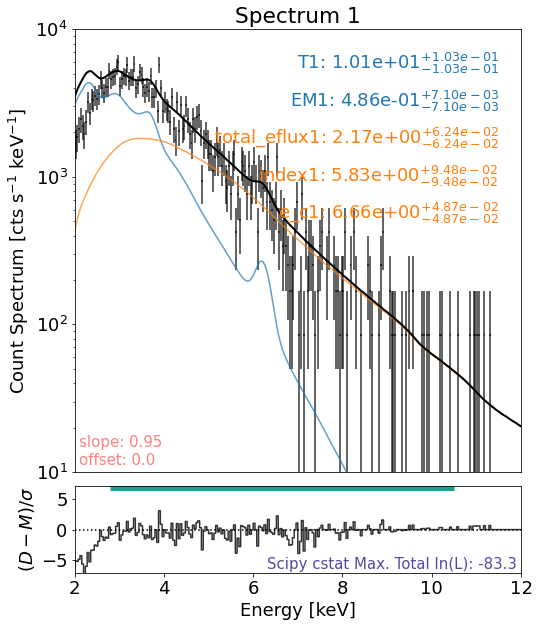

CPU times: user 1min 7s, sys: 14 s, total: 1min 21s
Wall time: 29.2 s


In [42]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/Lindsays_NonThermalEvent/"
# in the files I have, the ARF and RMF file have different names to the PHA files so cannot use the PHA file name to help find the others so...
spec = SunXspex(pha_file=_dir+'nu20312001001B06_cl_grade0_sr_grp.pha',
                arf_file=_dir+'nu20312001001B06_cl_grade0_sr.arf',
                rmf_file=_dir+'nu20312001001B06_cl_grade0_sr.rmf')
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "f_vth + thick_fn"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

# sort temperature param from f_vth
spec.params["T1_spectrum1"] = {"Value":10.3, "Bounds":(1.1, 15)}
# emission measure param from f_vth
spec.params["EM1_spectrum1"] = {"Value":0.5, "Bounds":(1e-2, 1e1)}
# electron flux param from thick_fn
spec.params["total_eflux1_spectrum1"] = {"Value":2.1, "Bounds":(1e-3, 10)} # units 1e35 e^-/s
# electron index param from thick_fn
spec.params["index1_spectrum1"] = {"Value":6.2, "Bounds":(3, 10)}
# electron low energy cut-off param from thick_fn
spec.params["e_c1_spectrum1"] = {"Value":6.2, "Bounds":(1, 12)} # units keV
# constant for systematic offset between FPMs, found to be about 1.1
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}

# fit the model to the spectrum
spec.fit(tol=1e-8)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

### Let's recreate Figure 3(c) where both NuSTAR FPMs are fitted with a thermal+cold thick target model simultaneously.

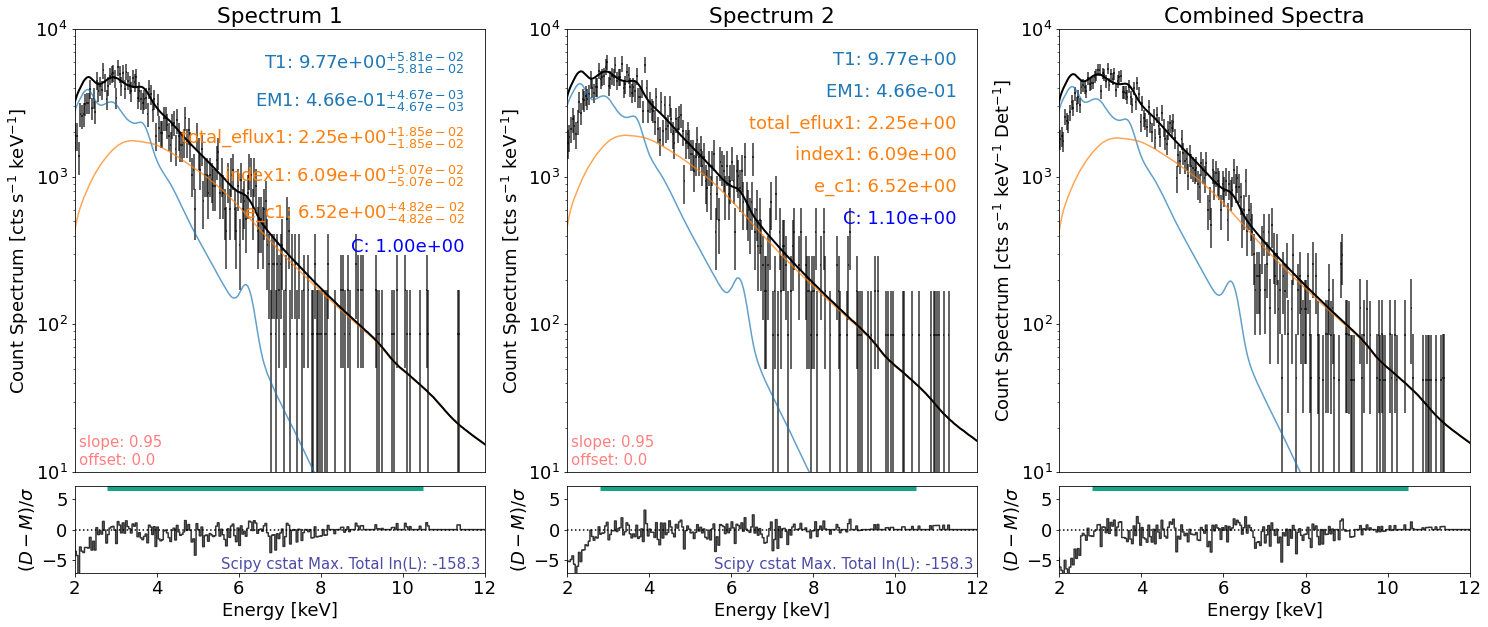

CPU times: user 2min 16s, sys: 28 s, total: 2min 44s
Wall time: 54.7 s


In [43]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/Lindsays_NonThermalEvent/"
# in the files I have, the ARF and RMF file have different names to the PHA files so cannot use the PHA file name to help find the others so...
spec = SunXspex(pha_file=[_dir+'nu20312001001A06_cl_grade0_sr_grp.pha',
                          _dir+'nu20312001001B06_cl_grade0_sr_grp.pha'],
                arf_file=[_dir+'nu20312001001A06_cl_grade0_sr.arf',
                          _dir+'nu20312001001B06_cl_grade0_sr.arf'],
                rmf_file=[_dir+'nu20312001001A06_cl_grade0_sr.rmf',
                          _dir+'nu20312001001B06_cl_grade0_sr.rmf'])
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "C*(f_vth + thick_fn)"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

# sort temperature param from f_vth
spec.params["T1_spectrum1"] = {"Value":10.3, "Bounds":(1.1, 15)}
# emission measure param from f_vth
spec.params["EM1_spectrum1"] = {"Value":0.5, "Bounds":(1e-2, 1e1)}
# electron flux param from thick_fn
spec.params["total_eflux1_spectrum1"] = {"Value":2.1, "Bounds":(1e-3, 10)} # units 1e35 e^-/s
# electron index param from thick_fn
spec.params["index1_spectrum1"] = {"Value":6.2, "Bounds":(3, 10)}
# electron low energy cut-off param from thick_fn
spec.params["e_c1_spectrum1"] = {"Value":6.2, "Bounds":(1, 12)} # units keV
# constant for systematic offset between FPMs, found to be about 1.1
spec.params["C_spectrum1"] = "frozen"
spec.params["C_spectrum2"] = {"Status":"fixed", "Value":1.1}
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}
spec.rParams["gain_slope_spectrum2"] = spec.rParams["gain_slope_spectrum1"]

# fit the model to the spectrum
spec.fit(tol=1e-8)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

For the thermal and cold thick target total model we compare:

| Model Parameter                  | OSPEX (Glesener et al. 2020, just FPMB)       |This Work (just FPMB)           | This Work (FPMA&B)                |
| :---                             |    :----:                                     |     :----:                     |                              ---: |
| Temperature [MK]                 | 10.3$^{+0.7}_{-0.7}$                          | 10.12$\pm$0.10                 | 9.77$\pm$0.06                     |
| Emission Measure [cm$^{-3}$]     | 5.0$^{+1.3}_{-1.3}\times$10$^{45}$            | 4.86$\pm$0.01$\times$10$^{45}$ | 4.66$\pm$0.05$\times$10$^{45}$    |
| Electron Flux [e$^{-}$ s$^{-1}$] | 2.1$^{+1.2}_{-1.2}\times$10$^{35}$            | 2.17$\pm$0.06$\times$10$^{35}$ | 2.25$\pm$0.02$\times$10$^{35}$    |
| Index                            | 6.2$^{+0.6}_{-0.6}$                           | 5.83$\pm$0.09                  | 6.09$\pm$0.05                     |
| Low Energy Cut-off [keV]         | 6.2$^{+0.9}_{-0.9}$                           | 6.66$\pm$0.05                  | 6.52$\pm$0.05                     |

## Now let's recreate Figure 4 (right) where NuSTAR FPMB is fitted with a warm thick target model.

### The warm thick target model helps to constrain the non-thermal emission with observed values (e.g., loop length, etc) and ties it to the thermal emission parameters.

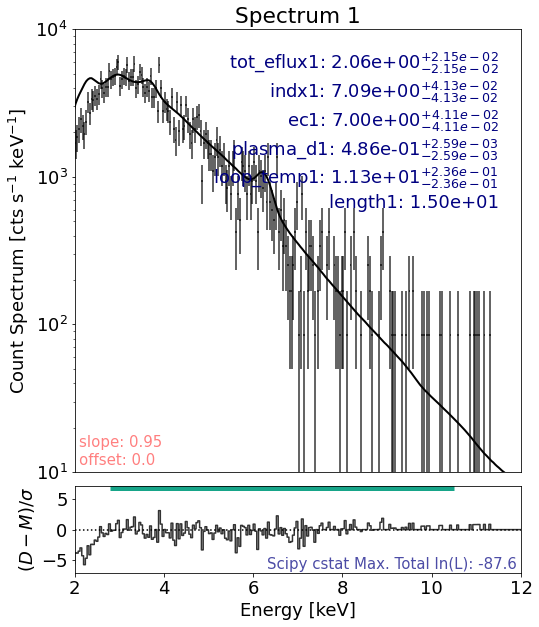

CPU times: user 1min 23s, sys: 18.9 s, total: 1min 42s
Wall time: 35.5 s


In [44]:
%%time
# First, load in your data files, here we load in 1 spectrum
_dir = "../nustarData/Lindsays_NonThermalEvent/"
spec = SunXspex(pha_file=_dir+'nu20312001001B06_cl_grade0_sr_grp.pha',
                arf_file=_dir+'nu20312001001B06_cl_grade0_sr.arf',
                rmf_file=_dir+'nu20312001001B06_cl_grade0_sr.rmf')
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "thick_warm"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

## Note that similar parameters in the warm thick target and cold thick target models have slightly different names
# electron flux param
spec.params["tot_eflux1_spectrum1"] = {"Value":2, "Bounds":(1e-2, 10)}
# electron index param
spec.params["indx1_spectrum1"] = {"Value":6, "Bounds":(3, 10)}
# electron low energy cut-off param 
spec.params["ec1_spectrum1"] = {"Value":7, "Bounds":(3, 12)}
# loop plasma temperature param 
spec.params["loop_temp1_spectrum1"] = {"Value":10, "Bounds":(5, 15)}
# plasma number density param 
spec.params["plasma_d1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e1)} # units 1e10 cm^-3
# loop length param 
spec.params["length1_spectrum1"] = {"Status":"fixed", "Value":15} # units Mm
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}

# fit the model to the spectrum
spec.fit(tol=1e-10)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

#### Here we can now fit the warm thick target model to both FPMs simultaneously

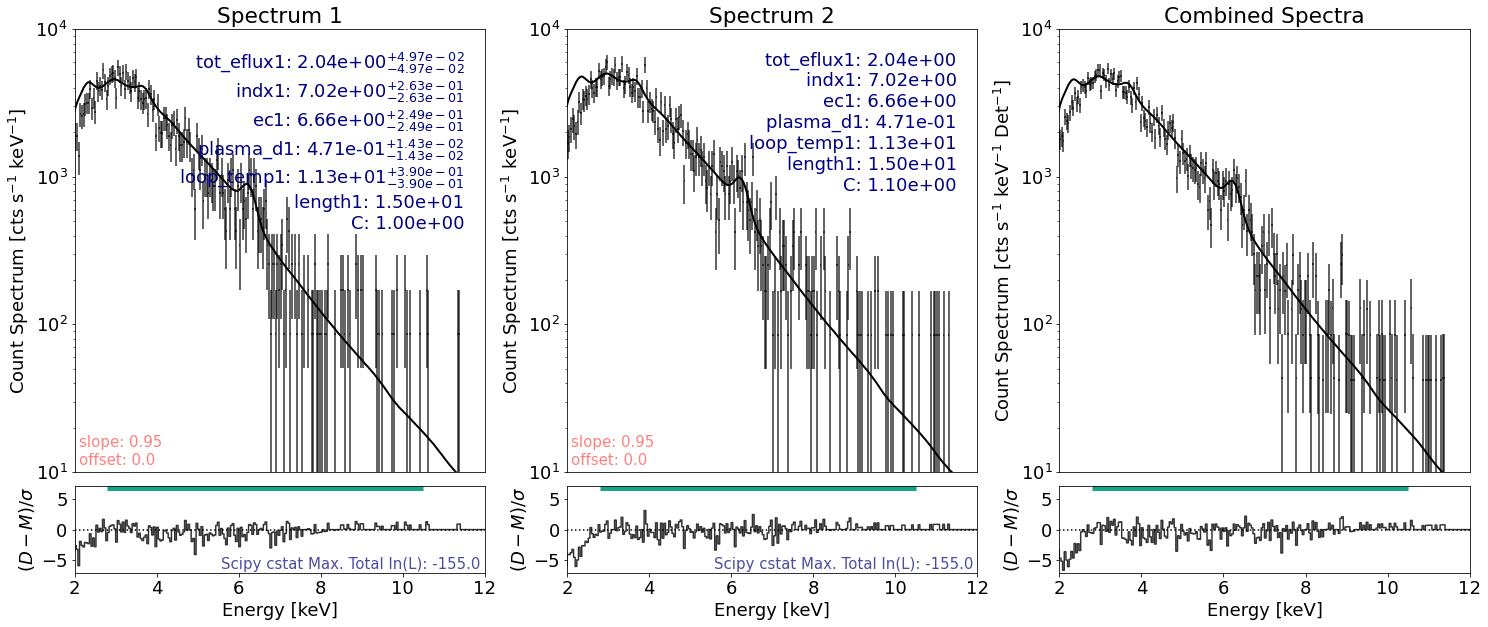

CPU times: user 1min 59s, sys: 25.7 s, total: 2min 25s
Wall time: 54.4 s


In [45]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/Lindsays_NonThermalEvent/"
spec = SunXspex(pha_file=[_dir+'nu20312001001A06_cl_grade0_sr_grp.pha',
                          _dir+'nu20312001001B06_cl_grade0_sr_grp.pha'],
                arf_file=[_dir+'nu20312001001A06_cl_grade0_sr.arf',
                          _dir+'nu20312001001B06_cl_grade0_sr.arf'],
                rmf_file=[_dir+'nu20312001001A06_cl_grade0_sr.rmf',
                          _dir+'nu20312001001B06_cl_grade0_sr.rmf'])
                
# define model, here we go for a single isothermal model + cold thick model
spec.model = "C*thick_warm"

# define fitting range
spec.energy_fitting_range = [2.8,10.5]

## Note that similar parameters in the warm thick target and cold thick target models have slightly different names
# electron flux param
spec.params["tot_eflux1_spectrum1"] = {"Value":2, "Bounds":(1e-3, 10)}
# electron index param
spec.params["indx1_spectrum1"] = {"Value":6, "Bounds":(3, 10)}
# electron low energy cut-off param 
spec.params["ec1_spectrum1"] = {"Value":7, "Bounds":(1, 12)}
# loop plasma temperature param 
spec.params["loop_temp1_spectrum1"] = {"Value":10, "Bounds":(1.1, 15)}
# plasma number density param 
spec.params["plasma_d1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e1)}
# loop length param 
spec.params["length1_spectrum1"] = {"Status":"fixed", "Value":15}
# constant for systematic offset between FPMs, found to be about 1.1
spec.params["C_spectrum1"] = "frozen"
spec.params["C_spectrum2"] = {"Status":"fixed", "Value":1.1}
# from Gles. 2020 which had a gain correction fixed at 0.95
spec.rParams["gain_slope_spectrum1"] = {"Status":"fixed", "Value":0.95}
spec.rParams["gain_slope_spectrum2"] = spec.rParams["gain_slope_spectrum1"]

# fit the model to the spectrum
spec.fit(tol=1e-5)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(gles_xlims)
    a.set_ylim(gles_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

For the warm thick target total model

| Model Parameter                  | OSPEX (Glesener et al. 2020, just FPMB) |This Work (just FPMB)            | This Work (FPMA&B)              |
| :---                             |    :----:                               |     :----:                      |                            ---: |
| Temperature [MK]                 | 10.2$^{+0.7}_{-0.7}$                    | 11.34$\pm$0.24                  | 11.27$\pm$0.39                  |
| Plasma Density [cm$^{-3}$]       | 6.0$^{+2.0}_{-2.0}\times$10$^{9}$       | 4.86$\pm$0.03$\times$10$^{9}$   | 4.71$\pm$0.14$\times$10$^{9}$   |
| Electron Flux [e$^{-}$ s$^{-1}$] | 1.8$^{+0.8}_{-0.8}\times$10$^{35}$      | 2.06$\pm$0.02$\times$10$^{35}$  | 2.04$\pm$0.05$\times$10$^{35}$  |
| Index                            | 6.3$^{+0.7}_{-0.7}$                     | 7.09$\pm$0.04                   | 7.02$\pm$0.26                   |
| Low Energy Cut-off [keV]         | 6.5$^{+0.9}_{-0.9}$                     | 7.00$\pm$0.04                   | 6.66$\pm$0.25                   |

All parameter values appear to be within error margins (or extrememly close). This is more impresive when the errors calculated in this work for the minimised values assumes the parameter's have a Gaussian and independent posterior distribution (which is clearly not the case) and so these errors are likely to be larger; to be investigated with an MCMC.

The simultaneous fit of FPMA&B with the cold thick target model and the warm thick model is not able to be performed in OSPEX.

# An example of fitting multiple spectra simultaneously with 2 models where each model is allowed to vary at different times

We also allow the gain slope response parameter to vary.

This spectrum corresponds to the may1618 microflare in [Duncan *et al.* 2021](https://iopscience.iop.org/article/10.3847/1538-4357/abca3d).

In [46]:
# set up plotting info stuff
dunc_xlims, dunc_ylims = [2.5,11], [1e0,4e4]

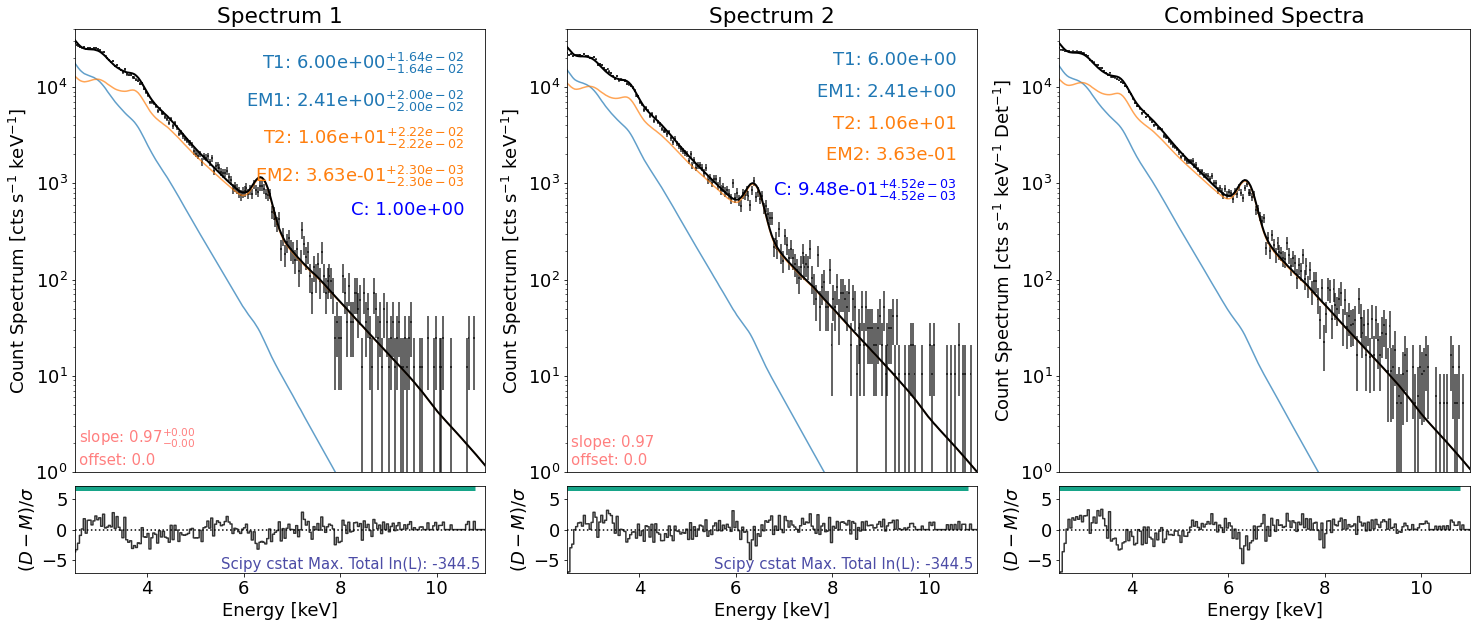

CPU times: user 2min 8s, sys: 23 s, total: 2min 31s
Wall time: 53.5 s


In [47]:
%%time
# First, load in your data files, here we load in 2 spectra
_dir = "../nustarData/jessies_spectra/"
spec = SunXspex(pha_file=[_dir+'nu80410201001A06_1618_p_chu2_N_sr.pha',
                          _dir+'nu80410201001B06_1618_p_chu2_N_sr.pha'])

# define model, here we go for 2 isothermal models
spec.model = "C*(f_vth + f_vth)"
                
# freeze the ones we don't want to vary
spec.params["C_spectrum1"] = {"Status":"frozen"}

# Set initial values
spec.params["T1_spectrum1"] = {"Value":4, "Bounds":(2.5, 6)}
spec.params["EM1_spectrum1"] = {"Value":10, "Bounds":(1e-1, 1e2)}     
spec.params["T2_spectrum1"] = {"Value":8, "Bounds":(5, 15)}                
spec.params["EM2_spectrum1"] = {"Value":0.5, "Bounds":(1e-4, 10)}                
spec.params["C_spectrum2"] = {"Status":"free", "Bounds":(0.5, 2)}


# Fit lower energy range with the first thermal model first
spec.params["T2_spectrum1"] = "frozen"
spec.params["EM2_spectrum1"] = "frozen"
spec.energy_fitting_range = [2.5,5]

spec.fit(tol=1e-6)


# Now fit higher energy range with the second thermal model
spec.params["T1_spectrum1"] = "frozen"
spec.params["EM1_spectrum1"] = "frozen"
spec.params["C_spectrum2"] = "frozen"
spec.params["T2_spectrum1"] = "free"
spec.params["EM2_spectrum1"] = "free"

# Need the gain slope to vary too for this microflare but only needed for the 6.7 keV line
spec.rParams["gain_slope_spectrum1"] = "free"
spec.rParams["gain_slope_spectrum2"] = spec.rParams["gain_slope_spectrum1"]

spec.energy_fitting_range = [5, 10.8]

spec.fit(tol=1e-6)


# Now free everything over full range
spec.params["T1_spectrum1"] = "free"
spec.params["EM1_spectrum1"] = "free"
spec.params["C_spectrum2"] = "free"

spec.energy_fitting_range = [2.5, 10.8]

spec.fit(tol=1e-10)

# plot the result
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim(dunc_xlims)
    a.set_ylim(dunc_ylims)
plt.show()
plt.rcParams['font.size'] = default_font_size

For the 2 thermal model fitting:

| Model Parameter                | XSPEC (Duncan et al. 2021)         | This Work                       |
| :---                           |    :----:                          |                            ---: |
| Temperature 1 [MK]             | 4.1$^{+0.2}_{-0.1}$                | 6.00$\pm$0.02                   |
| Emission Measure 1 [cm$^{-3}$] | 1.4$^{+0.6}_{-0.4}\times$10$^{47}$ | 2.41$\pm$0.02$\times$10$^{46}$  |
| Temperature 2 [MK]             | 10.00$^{+0.03}_{-0.03}$            | 10.63$\pm$0.02                  |
| Emission Measure 2 [cm$^{-3}$] | 4.6$^{+0.1}_{-0.2}\times$10$^{45}$ | 3.63$\pm$0.02$\times$10$^{45}$  |


| Response Parameter             | XSPEC (Duncan et al. 2021)         | This Work         |
| :---                           |    :----:                          |              ---: |
| Gain Slope                     | 0.977$\pm$0.002                    | 0.973$\pm$0.001   |

Although these values are slightly different, it is important to note that XSPEC and SunXspex work from different atomic databases. We also note that for a similar isothermal fit the temperature can drop/rise if the emission measure rises/drops and so fitting not just one but two of these models allows for these to vary more. We do see that this work (for this microflare) produces higher temperatures but correspondingly lower emission measures. 

***

**Code is still under construction. The vast majority of code has documentation but still working on it. Plotting code is generally a mess but, again, a work in progress.**

**Working on parallelisation for the MCMC. Numpy already does this for some calculations during the minimisation which gets in the road of the MCMC walker parallelisation.**

**Nested sampling is set up for model comparison, so the method `run_nested()` works but is very limited and has not been tested properly yet.**

***